# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


# magic word for producing visualizations in notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
#checking out the data, missing were data
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
#! ls ../../data/Term2/capstone/arvato_data/

In [5]:
#! cp ../../data/Term2/capstone/arvato_data/* . -fv

In [6]:
#! zip all.zip * .csv

In [7]:
#%%capture
#!aws s3 cp Zipall s3://sagemaker-us-east-1-467442072198/capstoneproject/ --recursive

In [8]:
attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
print('Data Loaded Successfully.......!')

Data Loaded Successfully.......!


In [9]:
#checking out the number of columns and rows
azdias.shape

(891221, 366)

In [10]:
#general information on columns
azdias.info()
#all the categorical data columns with unknown values
azdias.select_dtypes(include='object').nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               5162
OST_WEST_KZ                    2
dtype: int64

In [11]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [12]:
unknowns=azdias.isnull().sum().sum()
print('Total Unknown Values for the Population Dataset is: ',unknowns)

Total Unknown Values for the Population Dataset is:  33492923


In [13]:
attributes[attributes.Meaning.str.contains('know',na=False)]

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,NaN,ANREDE_KZ,gender,"-1, 0",unknown
40,NaN,BALLRAUM,distance to next urban centre,-1,unknown
48,NaN,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,NaN,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,NaN,CJT_GESAMTTYP,customer journey typology,0,unknown
138,NaN,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known


In [14]:
#displaying rows of customers dataset
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [15]:
customers.info()
customers.select_dtypes(include='object').nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               3034
OST_WEST_KZ                    2
PRODUCT_GROUP                  3
CUSTOMER_GROUP                 2
dtype: int64

In [16]:
customers.select_dtypes(include='object').nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               3034
OST_WEST_KZ                    2
PRODUCT_GROUP                  3
CUSTOMER_GROUP                 2
dtype: int64

In [17]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [18]:
unknowns2=customers.isnull().sum().sum()
print('Total Unknown Values for the Customers Dataset is: ',unknowns2)

Total Unknown Values for the Customers Dataset is:  13864522


In [19]:
customers.CUSTOMER_GROUP.value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [20]:
population = azdias.sample(n=5000)
customers= customers.sample(n=5000)
print(population.shape,customers.shape)

(5000, 366) (5000, 369)


In [21]:
#label encoding
customers.replace({'PRODUCT_GROUP':{'COSMETIC':0,'FOOD':1,'COSMETIC_AND_FOOD':2},
                   'CUSTOMER_GROUP':{'MULTI_BUYER':0,'SINGLE_BUYER':1}
                   },inplace=True)


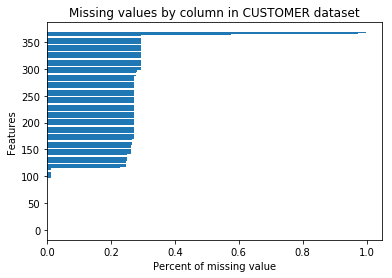

In [22]:
#Customer columns with missing values
plt.barh(np.arange(len(customers.columns)), customers.isnull().mean().sort_values(ascending=True))
plt.xlabel('Percent of missing value')
plt.ylabel('Features')
plt.title('Missing values by column in CUSTOMER dataset')
plt.show()

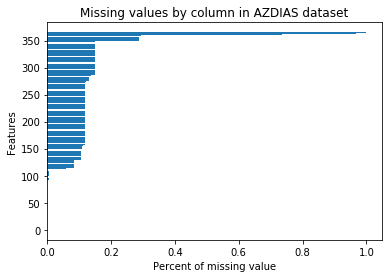

In [23]:
#azdias columns with missing values
plt.barh(np.arange(len(azdias.columns)), azdias.isnull().mean().sort_values(ascending=True))
plt.xlabel('Percent of missing value')
plt.ylabel('Features')
plt.title('Missing values by column in AZDIAS dataset')
plt.show()

In [23]:
customers.select_dtypes(include='object').nunique()

CAMEO_DEU_2015               45
CAMEO_DEUG_2015              19
CAMEO_INTL_2015              43
D19_LETZTER_KAUF_BRANCHE     34
EINGEFUEGT_AM               477
OST_WEST_KZ                   2
dtype: int64

In [24]:
def drop_cols(df):
    '''
    function that drops columns that 
    have more than 30% data that is missing/contains NaNs
    '''
    #finding columns with 30% missing data
    #print("==========================")
    print('Old Data shape: ',df.shape)
    
    df_1 = (df.isnull().sum()/df.shape[0])>0.3
    df_2 = df[df.columns[~df_1]]
    print('=============================')
    print("New Data shape: ", df_2.shape)
    print('=============================')
    
    return df_2

In [25]:
def identify_nas(attributes):
    '''
    function that shows which values are unknowns in the
    attributes dataframe
    '''
    df=attributes.copy()
    df = df[df.Meaning.str.contains('know',na=False)].reset_index(drop=True)
    
    s = df['Value'].str.split(',').apply(pd.Series, 1).stack() #splits the valaues in that column
    s.index = s.index.droplevel(1)
    s.name='New_value'
    df = df.join(s)  #joins with the new value
    df.loc[df.New_value.isna(),'New_value']=df[~df.Value.str.contains(',',na=False)].Value  #locates the values
    df.reset_index(drop=True,inplace=True)
    df['New_value']=df['New_value'].astype(float)
    
    return df

def unknown_nas(df,new_attributes):

  '''
    this function replaces all unknowns(-1,0,9,10) with NaN
    '''
  df_1 = df.copy()
  cols = df_1.columns.intersection(new_attributes.columns)
  for i in range(len(new_attributes[cols])):
    value = new_attributes.loc[i,'New_value']
    col = new_attributes.loc[0,'Attribute']
    mask = df_1[col] == value
    df_1[mask]= np.nan
        
    return df_1

In [26]:
def impute_nas(df,new_attributes):
    '''
    this function performs data imputation on the remaining dataset
    '''
    dt=new_attributes.copy()
    data=df.copy()
    
    dt=dt[dt.Meaning.str.contains('numeric',na=False)]

    print("Number of Nas before filling : {}".format(data.isnull().sum().sum()))
    # Numerical features => Median
    mask = dt.Attribute.values
    data[mask]= data[mask].fillna(data.median())
    print("Number of Nas after filling Numeric features : {}".format(data.isnull().sum().sum()))
    
    # Categorical features => Most frequent (Mode)
    mask = data.columns.difference(mask)
    data[mask]= data[mask].fillna(data.mode().iloc[0])
    print("Number of Nas after  filling All features: {}".format(data.isnull().sum().sum()))
    
    return data

In [35]:
def encode_data(df,new_attributes):

    #label encoding
    

    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    
    for col in cols:
        if col in df.columns:
            # Replace non-numeric values with NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df[cols] = df[cols].astype(float)
    df.fillna(0,inplace=True)

    # drop some features
    cols= ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM','OST_WEST_KZ']
    df=df.drop(columns=cols,axis=1)

    # Scale numerical Numerical features
    scaler = StandardScaler()
    scaled_arr = scaler.fit_transform(df)
    data_scaled = pd.DataFrame(scaled_arr, columns = df.columns)
    df =data_scaled

    return df


In [36]:
def clean_data(data,attributes):
    '''
    Clean data from beginning to end
  
    '''
    # clean description data
    print("Cleaning attributes data ...")
    new_attributes = identify_nas(attributes)
    print('==============================')
    # delete Nas
    print("Deleting Nas columns ...")
    data = drop_cols(data)
    print('==============================')
    # replace Unknown by  Nas
    print("Replacing Unknowns by Nas ...")
    data = unknown_nas(data,new_attributes)
    print('==============================')
    # input nas
    print("Imputing data ...")
    data = impute_nas(data,new_attributes)
    print('==============================')
    # encode data
    print("Encoding data ...")
    data = encode_data(data,new_attributes)
    
    data.fillna(method='ffill',inplace=True)
    print('==============================')
    print('Final data size: ',data.shape)
    
    return data

In [37]:
encode_data(population,attributes)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1.496230,-0.539585,-1.087504,-1.258630,-0.300370,-0.175434,-0.078085,-0.045997,-1.248408,-0.462384,...,-1.502331,-1.695548,-1.825977,-1.718904,-1.513694,-2.448602,-1.604149,-0.276528,0.971992,-0.730212
1,-0.973047,-0.539585,-0.816238,1.412433,-0.300370,-0.175434,-0.078085,-0.045997,0.593911,-0.340018,...,-0.046584,-0.138399,0.322990,0.521753,-0.188140,-0.397961,1.498825,-0.276528,0.971992,0.215414
2,-1.555199,-0.539585,1.353887,0.776465,-0.300370,-0.175434,-0.078085,-0.045997,-1.248408,-0.095286,...,-0.774458,0.484460,0.322990,-0.118435,-0.188140,0.627360,1.498825,-0.276528,-1.028815,0.215414
3,-0.396087,-0.539585,-0.816238,1.412433,3.533674,7.390011,-0.078085,-0.045997,0.857099,-0.401201,...,-1.502331,-0.449829,-0.482873,-0.438529,-1.071843,0.627360,-0.274303,-1.771273,-1.028815,0.215414
4,0.491133,1.118127,-0.816238,0.013304,-0.300370,-0.175434,-0.078085,-0.045997,0.067534,-0.217652,...,-0.046584,-0.138399,0.322990,0.201659,1.137414,0.627360,1.498825,0.470845,0.971992,1.161040
5,-1.379573,-0.539585,1.353887,-1.258630,-0.300370,-0.175434,-0.078085,-0.045997,-1.248408,-0.462384,...,-1.502331,1.107319,0.054369,-0.438529,-1.513694,0.627360,-1.604149,-0.276528,-1.028815,0.215414
6,-0.734782,-0.539585,-0.816238,1.412433,-0.300370,-0.175434,-0.078085,-0.045997,0.593911,-0.401201,...,-1.502331,-0.761259,-0.482873,-0.438529,-0.629992,0.627360,1.498825,-1.771273,0.971992,0.215414
7,0.361259,2.775839,-0.816238,0.267691,-0.300370,-0.175434,-0.078085,-0.045997,0.330723,-0.401201,...,-0.046584,-0.449829,-1.020115,-1.078716,1.137414,0.627360,-0.717585,-1.771273,0.971992,0.215414
8,-0.929477,-0.539585,-1.087504,-1.258630,-0.300370,-0.175434,-0.078085,-0.045997,-1.248408,-0.462384,...,-1.502331,-1.695548,-1.825977,-1.718904,-1.513694,-2.448602,-1.604149,-0.276528,0.971992,0.215414
9,0.203795,1.946983,-0.816238,-0.113889,-0.300370,-0.175434,-0.078085,-0.045997,-0.064060,-0.401201,...,-0.046584,0.795890,-0.214252,-0.758622,1.137414,0.627360,0.168979,-1.771273,-1.028815,1.161040


In [38]:
population = clean_data(population, attributes)
customers = clean_data(customers,attributes)

Cleaning attributes data ...
Deleting Nas columns ...
Old Data shape:  (5000, 366)
New Data shape:  (5000, 366)
Replacing Unknowns by Nas ...
Imputing data ...
Number of Nas before filling : 1385676
Number of Nas after filling Numeric features : 1385676
Number of Nas after  filling All features: 0
Encoding data ...
Final data size:  (5000, 362)
Cleaning attributes data ...
Deleting Nas columns ...
Old Data shape:  (5000, 369)
New Data shape:  (5000, 363)
Replacing Unknowns by Nas ...
Imputing data ...
Number of Nas before filling : 906001
Number of Nas after filling Numeric features : 906001
Number of Nas after  filling All features: 0
Encoding data ...
Final data size:  (5000, 359)


In [40]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 359 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(359)
memory usage: 13.7 MB


In [43]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.795406,0.382741,-0.221058,-0.153782,-0.008579,-0.167468,-0.089976,-0.130098,-0.153557,-0.157848,...,-0.537391,0.494879,0.183153,-0.215783,0.395188,0.517697,-0.427308,-0.162737,-0.437734,0.355148
1,0.919324,0.382741,4.676832,-0.408474,-0.761146,0.311467,-0.089976,-0.130098,-0.153557,0.399020,...,0.722907,0.494879,-7.981186,-0.215783,0.395188,0.517697,-0.427308,-0.162737,2.284492,0.355148
2,-0.780505,2.229949,-0.221058,-2.700694,1.496555,-0.167468,-0.089976,-0.130098,-0.153557,-0.157848,...,1.983206,0.494879,0.183153,2.449846,-1.771415,0.517697,-0.427308,-0.162737,-0.437734,-5.466956
3,-0.795406,0.382741,-0.221058,-0.153782,-0.008579,-0.167468,-0.089976,-0.130098,-0.153557,-0.157848,...,-0.537391,0.494879,0.183153,-0.215783,0.395188,0.517697,-0.427308,-0.162737,-0.437734,0.355148
4,0.309896,0.382741,-0.221058,0.610291,2.249122,-0.167468,-0.089976,-0.130098,-1.169145,-0.157848,...,5.764102,-3.390591,-2.538293,3.116253,1.478490,0.517697,-0.427308,-0.162737,2.284492,0.355148


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

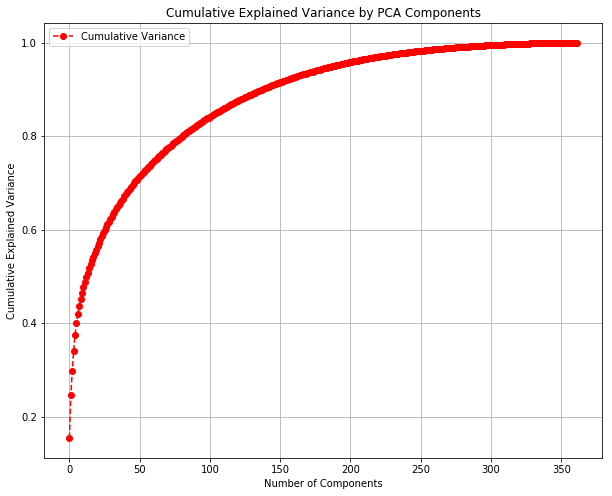

In [51]:
#obtaining the best features
pca = PCA() # init pca
pca.fit(population) # fit the dataset into pca model

num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
cumulativeValue = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 8))  # Define figure size
plt.plot(
    ind, 
    cumulativeValue, 
    marker='o', 
    linestyle='--', 
    color='red', 
    label='Cumulative Variance'
)  # Add plot with markers and dashed lines
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.show()

In [56]:
#obtaining columns that have explain 80% variance in the population dataset
df= pd.DataFrame(cumulativeValue,columns=["cum_variance"])
mask=df.cum_variance > 0.80
k=df[mask].index[0]

print('Columns with 80% variance: ',k)

Columns with 80% variance:  81


In [58]:
pca = PCA(n_components=81)
newpop_data = pca.fit_transform(population)
print('New Population Data after PCA: ',newpop_data.shape)

New Population Data after PCA:  (5000, 81)


In [59]:
pca = PCA(n_components=81) 
newcust_data=pca.fit_transform(customers)

In [60]:
#choosing the clusters using Different Cluster Number
DiffClusNum = []
for i in range(1,20):
  kmeans = KMeans(n_clusters = i, init = 'k-means++',random_state=42)
  kmeans.fit(newpop_data)
  DiffClusNum.append(kmeans.inertia_)

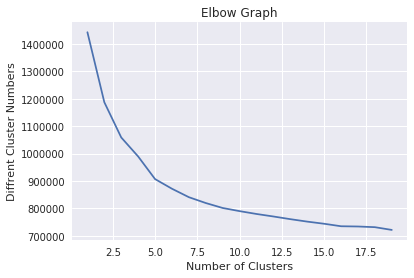

In [62]:
#plotting the elbow graph
sns.set()
plt.plot(range(1,20),DiffClusNum)
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Diffrent Cluster Numbers')
plt.show()

In [63]:
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0)
Y = kmeans.fit_predict(newpop_data)
print(Y)

Z= kmeans.fit_predict(newcust_data)
print(Z)

[0 0 0 ..., 0 0 0]
[0 5 7 ..., 0 1 7]


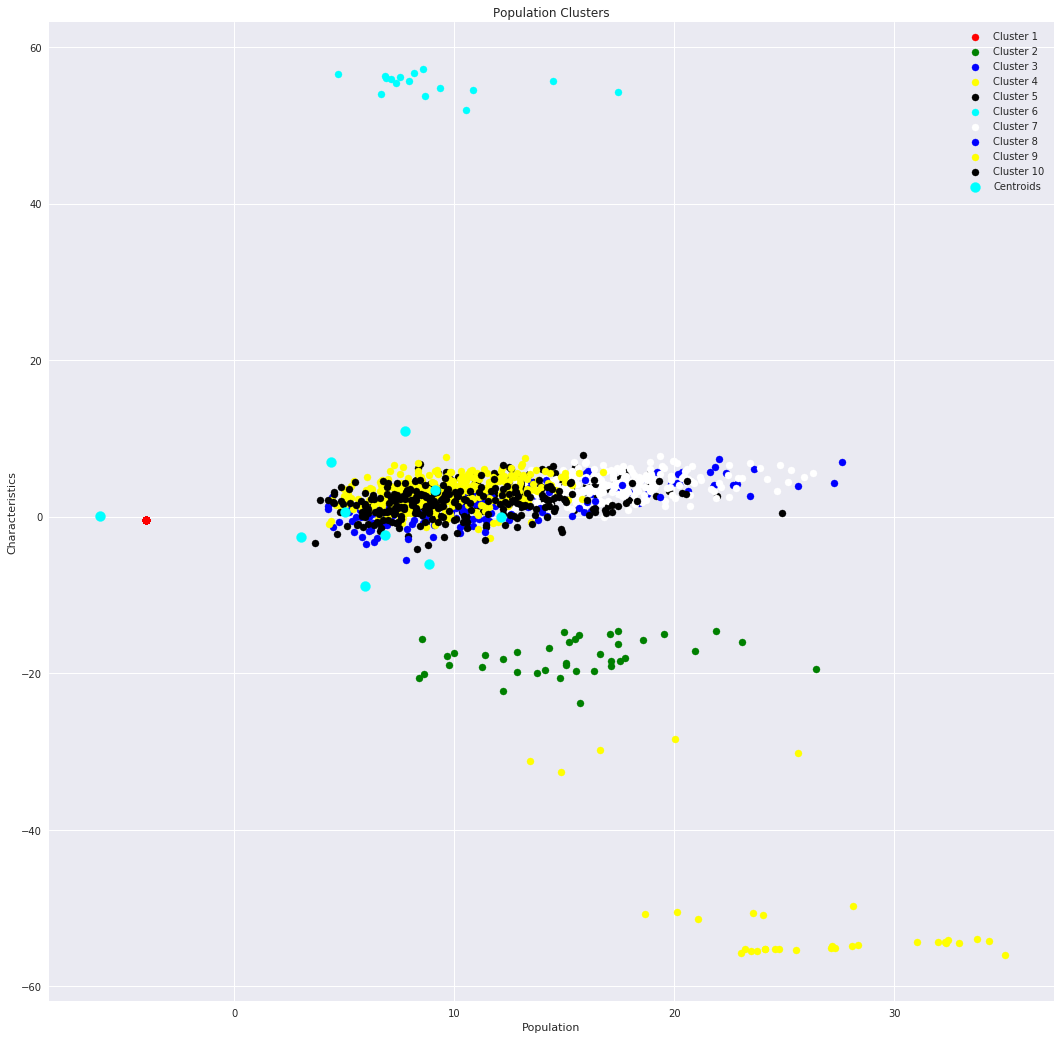

In [64]:
# Visualizing the clusters
plt.figure(figsize=(18, 18))

# Define cluster colors and labels
colors = ['red', 'green', 'blue', 'yellow', 'black', 'cyan', 'white', 'blue', 'yellow', 'black']
labels = [f'Cluster {i + 1}' for i in range(10)]

# Plot each cluster
for i in range(10):
    plt.scatter(
        newpop_data[Y == i, 0], 
        newpop_data[Y == i, 1], 
        s=50, 
        c=colors[i], 
        label=labels[i]
    )

# Plot centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], 
    kmeans.cluster_centers_[:, 1], 
    s=100, 
    c='cyan', 
    label='Centroids'
)

# Add title and labels
plt.title('Population Clusters')
plt.xlabel('Population')
plt.ylabel('Characteristics')
plt.legend()
plt.show()

In [65]:
# lets check out the clusters
cluster_info = pd.DataFrame([])

cluster_info["Population"] = pd.Series(Y).value_counts().sort_index()
cluster_info["Customers"] = pd.Series(Z).value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [66]:
cluster_info

,Cluster,Population,Customers
0,0,3786,2447
1,1,39,235
2,2,39,413
3,3,34,10
4,4,184,157
5,5,16,230
6,6,223,266
7,7,122,515
8,8,315,448
9,9,242,279


In [67]:
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(0)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(0)

In [68]:
cluster_info

,Cluster,Population,Customers,Pop_proportion,Cust_proportion
0,0,3786,2447,76.0,49.0
1,1,39,235,1.0,5.0
2,2,39,413,1.0,8.0
3,3,34,10,1.0,0.0
4,4,184,157,4.0,3.0
5,5,16,230,0.0,5.0
6,6,223,266,4.0,5.0
7,7,122,515,2.0,10.0
8,8,315,448,6.0,9.0
9,9,242,279,5.0,6.0


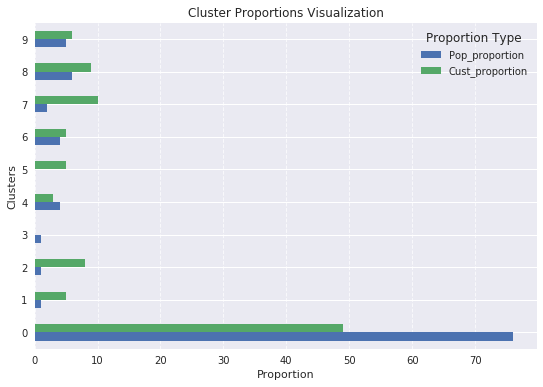

In [69]:
# Plotting cluster proportions
cluster_info[['Cluster', 'Pop_proportion', 'Cust_proportion']].plot(
    x='Cluster', 
    y=['Pop_proportion', 'Cust_proportion'], 
    kind='barh', 
    figsize=(9, 6)
)

# Adding title and labels
plt.title('Cluster Proportions Visualization')
plt.xlabel('Proportion')  # Label the x-axis
plt.ylabel('Clusters')  # Label the y-axis
plt.legend(title='Proportion Type')  # Add legend with a title
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Optional grid for better readability

# Display the plot
plt.show()

In [70]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [71]:
mailout_train.shape

(42962, 367)

In [72]:
mailout_train.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42962.000000,42962.000000,35993.000000,35993.000000,1988.000000,756.000000,174.000000,41.000000,34807.000000,35185.000000,...,35695.000000,35695.000000,35695.000000,33284.000000,35993.000000,35185.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,42803.120129,0.542922,1.525241,10.285556,12.606137,13.783069,14.655172,14.195122,9.855058,6.706096,...,4.318644,4.505953,3.116963,4.488403,8.729947,4.059685,2.804199,0.012383,1.595084,3.213910
std,24778.339984,1.412924,1.741500,6.082610,3.924976,3.065817,2.615329,3.034959,4.373539,15.151790,...,3.165199,3.289502,2.534331,1.889573,1.010545,2.046697,1.121585,0.110589,0.490881,1.067475
min,1.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,21284.250000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
50%,42710.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,15.000000,10.000000,2.000000,...,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,0.000000,2.000000,4.000000
75%,64340.500000,2.000000,1.000000,15.000000,16.000000,16.000000,17.000000,17.000000,13.000000,7.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,85795.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,438.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [73]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [74]:
newmail_data=clean_data(mailout_train,attributes)

Cleaning attributes data ...
Deleting Nas columns ...
Old Data shape:  (42962, 367)
New Data shape:  (42962, 361)
Replacing Unknowns by Nas ...
Imputing data ...
Number of Nas before filling : 6671515
Number of Nas after filling Numeric features : 6671515
Number of Nas after  filling All features: 0
Encoding data ...
Final data size:  (42962, 357)


In [75]:
newmail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 357 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(357)
memory usage: 117.0 MB


In [76]:
newmail_data.RESPONSE.value_counts()

-0.089843     42618
 11.130568      344
Name: RESPONSE, dtype: int64

In [77]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(newmail_data.RESPONSE)

LabelEncoder()

In [78]:
le.classes_

array([ -0.08984268,  11.13056759])

In [79]:
le.transform

<bound method LabelEncoder.transform of LabelEncoder()>

In [85]:
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
y_encoded = lab_enc.fit_transform(newmail_data.RESPONSE)
print(utils.multiclass.type_of_target(newmail_data.RESPONSE))
print(utils.multiclass.type_of_target(newmail_data.RESPONSE.astype('int')))
print(utils.multiclass.type_of_target(y_encoded))

continuous
binary
binary


In [87]:
X = newmail_data.drop(['RESPONSE'], axis=1)
y = y_encoded
print(x.shape,y.shape)

(42962, 356) (42962,)


In [88]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .1, stratify = y, random_state = 1)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(38665, 356) (4297, 356) (38665,) (4297,)


In [89]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [90]:
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=123)
#create a dictionary for possible estimators then use gridsearch to test all values
params_rfc = {'n_estimators': [5,10,25,50,100, 200]}
rfc_gs = GridSearchCV(rfc, params_rfc, cv=5)
rfc_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 25, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [91]:
# Save best model
rfc_best = rfc_gs.best_estimator_
# Model's best n_estimators value
print(rfc_gs.best_params_)

{'n_estimators': 50}


In [ ]:
# Using a knn model
knn = KNeighborsClassifier()
#create a dictionary for possible estimators then use gridsearch to test all values
params_knn = {'n_neighbors': np.arange(1, 10)}
knn_gs = GridSearchCV(knn, params_knn, cv=5, n_jobs=-1)
knn_gs.fit(X_train, y_train)

In [ ]:
# Save best model
knn_best = knn_gs.best_estimator_
# Model's best n_neigbors value
print(knn_gs.best_params_)

In [ ]:
#Using logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)

In [ ]:
print('knn: {}'.format(knn_best.score(X_test, Y_test)))
print('rf: {}'.format(rf_best.score(X_test, Y_test)))
print('log_reg: {}'.format(log_reg.score(X_test, Y_test)))

In [ ]:
from sklearn.ensemble import VotingClassifier
#VotingClassifer is used to determine best model
estimators=[('knn', knn_best), ('rf', rf_best), ('log_reg', log_reg)]
ensemble = VotingClassifier(estimators, voting='hard')
ensemble.fit(X_train, y_train)
print(ensemble.score(X_test, y_test))

In [ ]:
y_pred=ensemble.predict(X_test)

In [ ]:
# Get the confusion matrix 
confusion_matrix(y_test, y_pred)

In [ ]:
roc_auc=roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1])
print(roc_auc)

In [ ]:
y_pred_proba = log_reg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)
auc_score = metrics.roc_auc_score(y_test, y_pred_proba)

#plot the ROC_AUC curve 
plt.figure(figsize=(8, 6))  # Define figure size for better visualization
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color="green")  # Format AUC for clarity
plt.title('ROC Curve')  # Add title to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.3)  # Add grid for better readability
plt.legend(loc="lower right")  # Place the legend in the lower right
plt.show()